In [1]:
%load_ext autoreload
%autoreload 2

# Standard imports
from pathlib import Path
import sys

# Library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Util imports
sys.path.append("../../")

# Overlay station data to grids
Prepare gridded data to match station area of influence

### Input parameters

In [2]:
CITY_NAME = "Mandaue"
STATION_NAMES = ["Mactan"]
SUFFIX = ""  # add underscore, only for Cagayan de Oro
VARS = ["precip", "tmax", "tmin"]
STATION_RESOLUTION_DEGREES = 0.25

RAW_PATH = Path("../../data/01-raw")
PROCESSED_PATH = Path("../../data/02-processed")
CORRECTED_PATH = PROCESSED_PATH / "bias-correction-radial-optimized"
CORRECTED_PATH.mkdir(parents=True, exist_ok=True)

DOMAINS_GEOJSON = RAW_PATH / "domains/downscaling_domains_fixed.geojson"
DOMAINS_CSV = RAW_PATH / "domains/'downscaling_domains_fixed.csv'"
STATION_LOCATION_CSV = RAW_PATH / "station_data/PAGASA_station_locations.csv"
STATION_DATA_CSV = PROCESSED_PATH / "station_data.csv"

STATION_NC = CORRECTED_PATH / f"station_{CITY_NAME.lower()}{SUFFIX.lower()}.nc"
GRIDDED_NC = (
    PROCESSED_PATH
    / f"input/chirts_chirps_regridded_interpolated_{CITY_NAME.lower()}.nc"
)
GRIDDED_SUBSET_NC = CORRECTED_PATH / f"gridded_{CITY_NAME.lower()}{SUFFIX.lower()}.nc"

## Station data

### Load station location

In [3]:
station_locations_df = pd.read_csv(STATION_LOCATION_CSV)
station_locations_df.head()
station_lats = station_locations_df.loc[
    station_locations_df["station_name"].isin(STATION_NAMES), "lat"
]
station_lons = station_locations_df.loc[
    station_locations_df["station_name"].isin(STATION_NAMES), "lon"
]
station_lat = station_lats.item() if len(station_lats) == 1 else station_lats.mean()
station_lon = station_lons.item() if len(station_lons) == 1 else station_lons.mean()

In [4]:
station_locations_df

,station_name,lat,lon,elevation
0,CLSU,15.735860,120.936800,7.600
1,Cabanatuan,15.470387,120.951143,32.000
2,Dagupan,16.086784,120.352045,2.000
3,Davao City,7.127577,125.654969,17.290
4,El Salvador,8.535701,124.557946,8.902
5,Lumbia,8.403330,124.555000,182.000
6,Legazpi,13.150937,123.728605,15.487
7,Mactan,10.322329,123.980118,24.300
8,NAIA,14.504700,121.004751,21.000
9,Port Area,14.588410,120.967866,15.000


### Load station data

In [5]:
stations_df = pd.read_csv(STATION_DATA_CSV)
station_df = (
    stations_df[stations_df["station"].isin(STATION_NAMES)]
    .drop_duplicates()
    .replace(-999, np.nan)
    .rename(columns={"rainfall": "precip"})
    .groupby(["station", "date"])
    .mean()
    .sort_values("date")
    .reset_index()
)
station_df.head()

,station,date,precip,tmax,tmin,tmean,rh,wind_speed,wind_direction
0,Mactan,2007-01-01,6.6,30.2,23.7,27.0,89.0,3.0,350.0
1,Mactan,2007-01-02,1.9,30.2,24.8,27.5,88.0,3.0,360.0
2,Mactan,2007-01-03,1.0,30.0,24.2,27.1,86.0,3.0,40.0
3,Mactan,2007-01-04,13.6,27.0,23.5,25.3,91.0,2.0,360.0
4,Mactan,2007-01-05,4.6,28.0,23.8,25.9,90.0,3.0,360.0


### Arrange as a Dataset

In [6]:
station_ds = (
    xr.Dataset(
        data_vars={
            var: (
                ["time", "lat"],
                station_df[var]
                .to_numpy()
                .reshape((len(station_df["date"].unique()), len(station_lats))),
            )
            for var in VARS
        },
        coords=dict(
            time=("time", pd.DatetimeIndex(station_df["date"].unique())),
            lat=("lat", station_lats),
        ),
        attrs=dict(
            description="Station data",
        ),
    )
    .expand_dims(lon=len(station_lons))
    .assign_coords(lon=station_lons)
    .transpose("time", "lat", "lon")
)
station_ds

<xarray.Dataset>
Dimensions:  (lon: 1, time: 3288, lat: 1)
Coordinates:
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2021-12-31
  * lat      (lat) float64 10.32
  * lon      (lon) float64 124.0
Data variables:
    precip   (time, lat, lon) float64 6.6 1.9 1.0 13.6 4.6 ... 7.8 7.5 15.5 7.6
    tmax     (time, lat, lon) float64 30.2 30.2 30.0 27.0 ... 26.7 29.0 26.6
    tmin     (time, lat, lon) float64 23.7 24.8 24.2 23.5 ... 23.4 24.5 24.1
Attributes:
    description:  Station data

In [7]:
station_ds.to_netcdf(STATION_NC, engine="scipy")

## Gridded data

### Load gridded data

In [16]:
gridded_ds = xr.open_dataset(GRIDDED_NC, engine="scipy").sel(band=1)
gridded_ds

<xarray.Dataset>
Dimensions:      (time: 7305, lat: 15, lon: 15)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2022-12-31
  * lat          (lat) float64 10.21 10.23 10.25 10.27 ... 10.45 10.47 10.49
  * lon          (lon) float64 123.8 123.8 123.8 123.8 ... 124.0 124.0 124.1
    band         int32 1
    spatial_ref  int32 ...
Data variables:
    tmin         (time, lat, lon) float32 ...
    tmax         (time, lat, lon) float32 ...
    precip       (time, lat, lon) float32 ...
Attributes: (12/16)
    Conventions:    CF-1.6
    title:          dataVersion 1.0
    history:        created by Climate Hazards Center
    version:        Version 1.0
    date_created:   2023-05-15
    creator_name:   Pete Peterson
    ...             ...
    website:        https://chc.ucsb.edu/data/chirtsmonthly    https://chc.uc...
    comments:       
    reference-1:    Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    reference-2:    Verdin, A. et al. Development and validation of the CHIRT...
    reference-3:    Tuholske, C., Caylor, K., Funk, C., Verdin, A., Sweeney, ...
    regrid_method:  bilinear

In [17]:
gridded_ds

<xarray.Dataset>
Dimensions:      (time: 7305, lat: 15, lon: 15)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2022-12-31
  * lat          (lat) float64 10.21 10.23 10.25 10.27 ... 10.45 10.47 10.49
  * lon          (lon) float64 123.8 123.8 123.8 123.8 ... 124.0 124.0 124.1
    band         int32 1
    spatial_ref  int32 ...
Data variables:
    tmin         (time, lat, lon) float32 ...
    tmax         (time, lat, lon) float32 ...
    precip       (time, lat, lon) float32 ...
Attributes: (12/16)
    Conventions:    CF-1.6
    title:          dataVersion 1.0
    history:        created by Climate Hazards Center
    version:        Version 1.0
    date_created:   2023-05-15
    creator_name:   Pete Peterson
    ...             ...
    website:        https://chc.ucsb.edu/data/chirtsmonthly    https://chc.uc...
    comments:       
    reference-1:    Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    reference-2:    Verdin, A. et al. Development and validation of the CHIRT...
    reference-3:    Tuholske, C., Caylor, K., Funk, C., Verdin, A., Sweeney, ...
    regrid_method:  bilinear

In [18]:
station_lat, station_lon

(10.322329, 123.980118)

In [19]:
station_buffer = STATION_RESOLUTION_DEGREES / 2
gridded_subset_ds = gridded_ds.where(
    (
        (gridded_ds.lat - station_lat) ** 2 + (gridded_ds.lon - station_lon) ** 2
        <= station_buffer**2
    ),
    drop=True,
)
gridded_subset_ds

<xarray.Dataset>
Dimensions:      (time: 7305, lat: 12, lon: 10)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2022-12-31
  * lat          (lat) float64 10.21 10.23 10.25 10.27 ... 10.39 10.41 10.43
  * lon          (lon) float64 123.9 123.9 123.9 123.9 ... 124.0 124.0 124.1
    band         int32 1
    spatial_ref  int32 0
Data variables:
    tmin         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    tmax         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    precip       (time, lat, lon) float32 nan nan nan nan ... 0.0 0.0 nan nan
Attributes: (12/16)
    Conventions:    CF-1.6
    title:          dataVersion 1.0
    history:        created by Climate Hazards Center
    version:        Version 1.0
    date_created:   2023-05-15
    creator_name:   Pete Peterson
    ...             ...
    website:        https://chc.ucsb.edu/data/chirtsmonthly    https://chc.uc...
    comments:       
    reference-1:    Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    reference-2:    Verdin, A. et al. Development and validation of the CHIRT...
    reference-3:    Tuholske, C., Caylor, K., Funk, C., Verdin, A., Sweeney, ...
    regrid_method:  bilinear

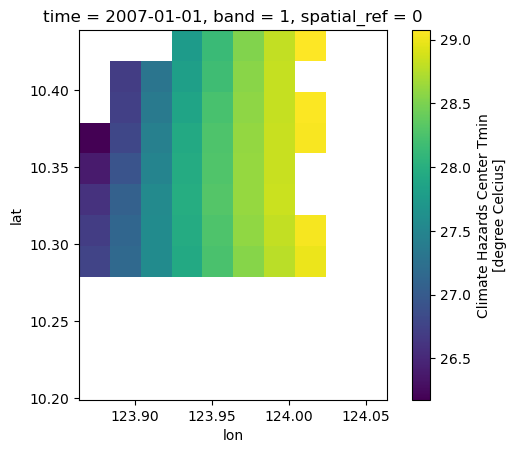

In [20]:
gridded_subset_ds["tmin"].sel(time="2007-01-01").plot()
ax = plt.gca()
ax.set_aspect(1)
plt.show()

In [21]:
GRIDDED_SUBSET_NC

PosixPath('../../data/02-processed/bias-correction-radial-optimized/gridded_mandaue.nc')

In [22]:
gridded_subset_ds.to_netcdf(GRIDDED_SUBSET_NC, engine="scipy")